# Description

This notebook implement and assesses EEG single trial classification of motor attempt on ten SCI patients using Linear, Multiclass, Probabilistic Support Tensor Machine, STM.

## Libs

In [1]:
import mne
from scipy import stats
from mne.stats import bonferroni_correction, fdr_correction
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
import pickle
import wget
import pandas as pd
import zipfile
import os
import shutil
import numpy as np
import time
from numpy.fft import rfft

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from spectrum import *
from scipy import fft
from scipy import signal
from scipy.stats import binom
from scipy.signal import butter, lfilter, filtfilt
import pystmm
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Functions

### 0. Get EEG Data as a Dataframe and as a MNE raw from BNCI Horizon

In [10]:
def getEEGData(URL, User):
    # Data Description: https://lampx.tugraz.at/~bci/database/001-2019/dataset_description_v1-1.pdf
    # Offline: Type run and event codes
    dictTypeRun =  {'Run 1':'EyeMovements',
                  'Run 2':'Rest',
                  'Run 3':'AttemptedMovement',
                  'Run 4':'AttemptedMovement',
                  'Run 5':'AttemptedMovement',
                  'Run 6':'AttemptedMovement',
                  'Run 7':'AttemptedMovement',
                  'Run 8':'EyeMovements',
                  'Run 9':'Rest',
                  'Run 10':'AttemptedMovement',
                  'Run 11':'AttemptedMovement',
                  'Run 12':'AttemptedMovement',
                  'Run 13':'AttemptedMovement',
                  'Run 14':'EyeMovements',
                  'Run 15':'Rest'
                 }
    dictEvents = dict(TrialStart = 0x300,
                    Beep = 0x311,
                    FixationCross = 0x312,
                    SupinationClassCue = 0x308,
                    PronationClassCue = 0x309,
                    HandOpenClassCue = 0x30B,
                    PalmarGraspClassCue = 0x39D,
                    LateralGraspClassCue = 0x39E)
    dictEvents = dict(zip([str(val) for val in list(dictEvents.values())],list(dictEvents.keys())))
    dictColNames = dict(zip(list(dictEvents.keys()), list(range(len(list(dictEvents.keys()))))))
  
    # Unzip on User folder
    try:
        shutil.rmtree(User)
        os.mkdir(User)
    except:
        os.mkdir(User)  
  
  
    if not os.path.exists(User+'.zip'):
        # Download file if not exist
        print('Downloading: ',User,' from ',URL+User+'.zip')
        filename = wget.download(URL+User+'.zip')
    else:
        filename = User+'.zip'


  
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(User)
    RunFiles = [os.path.join(User,f) for f in os.listdir(User) if os.path.isfile(os.path.join(User, f)) and f.lower().endswith('.gdf')]

    # Prepare DataFrame
    listDFRaw = []
    typeRun = []
    numRun = []
    samplingFrequencyList = []


  
    raw_all = mne.concatenate_raws([mne.io.read_raw_gdf(f, preload=True) for f in RunFiles])
    for run in dictTypeRun:
        rfile = None
        for runfile in RunFiles:
            if run in runfile:
                rfile = runfile
                break
        if rfile is None:
            continue
    
        raw = mne.io.read_raw_gdf(rfile)
    
        samplingFrequencyList.append(raw.info['sfreq'])
        ch_names = raw.info['ch_names']
        dfData = pd.DataFrame(data=raw.get_data().T,columns=ch_names)
        dfData = dfData.dropna(how='all')
        dfData.fillna(method='bfill',inplace=True)
        dfData = dfData.reset_index()
        dfData = dfData[ch_names]

        events, dictEventsRun = mne.events_from_annotations(raw)
        dictEventsRun = dict(zip([val for val in list(dictEventsRun.values())],list(dictEventsRun.keys())))
        sampleTime, eventNum = list(events[:,0]), list(events[:,2])
        listEventsPerColumn = [[0]*len(dfData)]*len(dictColNames)
        listEventsPerColumn = np.array(listEventsPerColumn)
        for s, e in zip(sampleTime, eventNum):
            if dictEventsRun[e] in dictColNames:
                listEventsPerColumn[dictColNames[dictEventsRun[e]],s] = 1
        dfEvents = pd.DataFrame(data=listEventsPerColumn.T,columns=[dictEvents[val] for val in list(dictColNames.keys())])
        dfRaw = pd.concat([dfEvents.copy(),dfData.copy()],axis=1,ignore_index=True)
        dfRaw.columns = [dictEvents[val] for val in list(dictColNames.keys())] + ch_names
    

        listDFRaw.append(dfRaw.copy())
        typeRun += [dictTypeRun[run]]*len(dfData)
        numRun += [run]*len(dfData)

    shutil.rmtree(User) 

    # Build DataFrame, MNE raw and return
    df = pd.concat(listDFRaw, ignore_index=True)
    df['TypeRun'] = typeRun
    df['Run'] = numRun
    df = df[['Run','TypeRun']+[dictEvents[val] for val in list(dictColNames.keys())]+ch_names]
    return df, raw_all, list(set(samplingFrequencyList))[0]

### 1. Multitaper spectral estimation

In [3]:
def multitaperSpectral(y, fs, NW=2.5,k=4):
    N=len(y)
    dt = 1.0/fs
    # The multitapered method
    [tapers, eigen] = dpss(N, NW, k)
    Sk_complex, weights, eigenvalues=pmtm(y, e=eigen, v=tapers, NFFT=N, show=False)
    Sk = abs(Sk_complex)**2
    Sk = np.mean(Sk * np.transpose(weights), axis=0) * dt
    return Sk

### 2. Band-pass filtering

In [4]:
def butterBandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butterBandpassFilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def dfBandpassFiltering(df,eeg_channels_of_interest,lowcut,highcut, fs, order):
    for col in eeg_channels_of_interest:
        df[col] = butter_bandpass_filter(df[col].values, lowcut, highcut, fs, order=5)
    return df

### 3. CAR filtering on Dataframe

In [5]:
def dfCARFiltering(df, channels_interest):
    dictData = df.to_dict(orient='list')
    for i in range(len(df)):
        meanVal = float(np.mean([float(dictData[col][i]) for col in channels_interest]))
        for col in channels_interest:
            dictData[col][i] = dictData[col][i] - meanVal
    df = pd.DataFrame(dictData)
    return df.copy()

### 4. Get Chance Level

In [6]:
def getChanceLevel(c,n,alpha):
    '''
    c: Number of classes
    n: total samples
    alpha: statistical significance level
    '''
    return (1/n)*binom.ppf(1-alpha, n, 1/c)

### 5. Confidence Intervals by Bootstrapping

In [7]:
# Retrived from: http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

## Main

### 0. Prepare Representations of Epochs per patients

In [13]:
users = ['P01','P02','P03','P04','P05','P06','P07','P08','P09','P10']
totalUsers = len(users)

eegChannels = ['AFz', 'F3', 'F1', 'Fz', 'F2', 'F4', 'FFC5h', 'FFC3h', 'FFC1h', 'FFC2h', 
                'FFC4h', 'FFC6h', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FCC5h', 
                'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h', 'C5', 'C3', 'C1', 'Cz', 'C2', 
                'C4', 'C6', 'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h', 'CP5', 
                'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'CPP5h', 'CPP3h', 'CPP1h', 'CPP2h', 
                'CPP4h', 'CPP6h', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PPO1h', 'PPO2h', 'POz']

movementTypes = ['HandOpenClassCue', 'PalmarGraspClassCue','LateralGraspClassCue']
classNames  = ['Rest'] +[val.replace('ClassCue','') for val in movementTypes]
additionalCols = ['Run','TypeRun','TrialStart','Beep','FixationCross']

tmin = -2.0
tmax = 3.0
NW = 2.5
totalTapers = 4

representationChannelTimeEpochs = []
representationChannelChanelTimeEpochs = []
representationChannelFrequencyEpochs = []
representationChannelChannelFrequencyEpochs = []

representationChannelTimeLabels = []
representationChannelChanelTimeLabels = []
representationChannelFrequencyLabels = []
representationChannelChannelFrequencyLabels = []

for indexUser in range(totalUsers):
    startProcessing = time.time()
    print('Preparing data for user: ', users[indexUser])
    print('Getting data ...')
    df, rawMNE, sfreq  = getEEGData(URL='http://bnci-horizon-2020.eu/database/data-sets/001-2019/', User=users[indexUser])
    
    listChannelTimeEpochs = []
    listChannelChanelTimeEpochs = []
    listChannelFrequencyEpochs = []
    listChannelChannelFrequencyEpochs = []
    
    listChannelTimeLabels = []
    listChannelChanelTimeLabels = []
    listChannelFrequencyLabels = []
    listChannelChannelFrequencyLabels = []
    
    dfFiltered = df[additionalCols+movementTypes+eegChannels]
    dfFiltered = dfCARFiltering(dfFiltered, eegChannels)

    ### 1. Getting REST EEG Epochs
    # Filter by TypeRun equal to Rest
    dfRest = dfFiltered[dfFiltered['TypeRun']=='Rest']
    dfRest.reset_index(inplace=True)
    #Signal rest
    signalRest = dfRest['TrialStart'].values.tolist()
    #Retrieve indexes where signal equals 1
    indexesOnes = [i for i,val in enumerate(signalRest) if val == 1]
    timesOnes = [val/(sfreq) for val in indexesOnes]
    consecutiveOnes = [timesOnes[i+1]-timesOnes[i] for i,val in enumerate(timesOnes) if i+1 < len(timesOnes)]

    #Estimating start and end for every rest epoch
    totalEpochs = 72
    epochsPerOnes = round(totalEpochs/len(indexesOnes))
    starts = []
    ends = []
    startstimes = []
    endstimes = []
    offset = 0.5*sfreq # One half second
    totalSamples = round(1 + ((tmax - tmin)*sfreq))
    steps = round(0.5*totalSamples)

    for starIndexOnes in indexesOnes:
        for i in range(epochsPerOnes):
            start = round(starIndexOnes+offset+(i*steps))
            starts.append(start)
            ends.append(start+totalSamples)

    #Transforming from sample to time
    startstimes = [val/(sfreq) for val in starts]
    endstimes = [val/(sfreq) for val in ends]

    epochsChannelTimeRest = []
    epochsChannelChannelRest = []
    epochsChannelFrequencyRest = []
    epochsChannelChannelFrequencyRest = []
    labelsRestEpochs = []
    print('Creating representations for REST...')
    for start,end in zip(starts,ends):
        epoch = dfRest.loc[start:end,eegChannels].values.T #Ch-Time Representation
        epochCov = np.cov(epoch)                                        #Ch-Ch (time) Representation
        epochMultitaper = np.zeros(epoch.shape)                         #Ch-Freq Representation
        for chann in range(epoch.shape[0]):
            r = multitaperSpectral(y=epoch[chann,:], fs=sfreq, NW=NW,k=totalTapers)
            epochMultitaper[chann,:] = r
        epochMultitaperCov = np.cov(epochMultitaper)                    #Ch-Ch (Freq.) Representation
        
        epochsChannelTimeRest.append(epoch.copy())
        epochsChannelChannelRest.append(epochCov.copy())
        epochsChannelFrequencyRest.append(epochMultitaper.copy())
        epochsChannelChannelFrequencyRest.append(epochMultitaperCov.copy())
        labelsRestEpochs.append(0)

    epochsChannelTimeRest = np.stack(epochsChannelTimeRest,axis=0)
    epochsChannelChannelRest = np.stack(epochsChannelChannelRest,axis=0)
    epochsChannelFrequencyRest = np.stack(epochsChannelFrequencyRest,axis=0)
    epochsChannelChannelFrequencyRest = np.stack(epochsChannelChannelFrequencyRest,axis=0)
    labelsRestEpochs = np.array(labelsRestEpochs)

    listChannelTimeEpochs.append(epochsChannelTimeRest.copy())
    listChannelChanelTimeEpochs.append(epochsChannelChannelRest.copy())
    listChannelFrequencyEpochs.append(epochsChannelFrequencyRest.copy())
    listChannelChannelFrequencyEpochs.append(epochsChannelChannelFrequencyRest.copy())
    listChannelTimeLabels.append(labelsRestEpochs.copy())
    listChannelChanelTimeLabels.append(labelsRestEpochs.copy())
    listChannelFrequencyLabels.append(labelsRestEpochs.copy())
    listChannelChannelFrequencyLabels.append(labelsRestEpochs.copy())
    

    ### 2. Getting MOTOR ATTEMPT EEG Epochs
    for it, mov in enumerate(movementTypes):
        print('Creating representations for ,',mov,'...')
        dfMA = dfFiltered[dfFiltered['TypeRun']=='AttemptedMovement']
        dfMA.reset_index(inplace=True)
        #Signal MA
        signalMA = dfMA[mov].values.tolist()
        #Retrieve indexes where signal equals 1
        indexesOnes = [i for i,val in enumerate(signalMA) if val == 1]
        timesOnes = [val/(sfreq) for val in indexesOnes]
        consecutiveOnes = [timesOnes[i+1]-timesOnes[i] for i,val in enumerate(timesOnes) if i+1 < len(timesOnes)]

        #Estimating start and end for every epoch
        totalSamples = round(1 + ((tmax - tmin)*sfreq))
        starts = []
        ends = []
        startstimes = []
        endstimes = []

        for starIndexOnes in indexesOnes:
            start = starIndexOnes + sfreq*tmin
            starts.append(start)
            ends.append(start+totalSamples)

        #Transforming from sample to time
        startstimes = [val/(sfreq) for val in starts]
        endstimes = [val/(sfreq) for val in ends]

        epochsChannelTimeMA = []
        epochsChannelChannelMA = []
        epochsChannelFrequencyMA = []
        epochsChannelChannelFrequencyMA = []
        labelsMAEpochs = []

        for start,end in zip(starts,ends):
            epoch = dfMA.loc[start:end,eegChannels].values.T #Ch-Time Representation
            epochCov = np.cov(epoch)                                        #Ch-Ch (time) Representation
            epochMultitaper = np.zeros(epoch.shape)                         #Ch-Freq Representation
            for chann in range(epoch.shape[0]):
                r = multitaperSpectral(y=epoch[chann,:], fs=sfreq, NW=NW,k=totalTapers)
                epochMultitaper[chann,:] = r
            epochMultitaperCov = np.cov(epochMultitaper)                    #Ch-Ch (Freq.) Representation

            epochsChannelTimeMA.append(epoch.copy())
            epochsChannelChannelMA.append(epochCov.copy())
            epochsChannelFrequencyMA.append(epochMultitaper.copy())
            epochsChannelChannelFrequencyMA.append(epochMultitaperCov.copy())
            labelsMAEpochs.append(it+1)

        epochsChannelTimeMA = np.stack(epochsChannelTimeMA,axis=0)
        epochsChannelChannelMA = np.stack(epochsChannelChannelMA,axis=0)
        epochsChannelFrequencyMA = np.stack(epochsChannelFrequencyMA,axis=0)
        epochsChannelChannelFrequencyMA = np.stack(epochsChannelChannelFrequencyMA,axis=0)
        labelsMAEpochs = np.array(labelsMAEpochs)

        listChannelTimeEpochs.append(epochsChannelTimeMA.copy())
        listChannelChanelTimeEpochs.append(epochsChannelChannelMA.copy())
        listChannelFrequencyEpochs.append(epochsChannelFrequencyMA.copy())
        listChannelChannelFrequencyEpochs.append(epochsChannelChannelFrequencyMA.copy())
        listChannelTimeLabels.append(labelsMAEpochs.copy())
        listChannelChanelTimeLabels.append(labelsMAEpochs.copy())
        listChannelFrequencyLabels.append(labelsMAEpochs.copy())
        listChannelChannelFrequencyLabels.append(labelsMAEpochs.copy())

    X = np.concatenate(listChannelTimeEpochs, axis=0)
    y = np.concatenate(listChannelTimeLabels)
    representationChannelTimeEpochs.append(X.copy())
    representationChannelTimeLabels.append(y.copy())
    X = np.concatenate(listChannelChanelTimeEpochs, axis=0)
    y = np.concatenate(listChannelChanelTimeLabels)
    representationChannelChanelTimeEpochs.append(X.copy())
    representationChannelChanelTimeLabels.append(y.copy())
    X = np.concatenate(listChannelFrequencyEpochs, axis=0)
    y = np.concatenate(listChannelFrequencyLabels)
    representationChannelFrequencyEpochs.append(X.copy())
    representationChannelFrequencyLabels.append(y.copy())
    X = np.concatenate(listChannelChannelFrequencyEpochs, axis=0)
    y = np.concatenate(listChannelChannelFrequencyLabels)
    representationChannelChannelFrequencyEpochs.append(X.copy())
    representationChannelChannelFrequencyLabels.append(y.copy())
    endProcessing = time.time()
    print('Time elapsed: ', str((endProcessing-startProcessing)/60.0),' min.')

Preparing data for user:  P01
Getting data ...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.99

Creating representations for , HandOpenClassCue ...
Creating representations for , PalmarGraspClassCue ...
Creating representations for , LateralGraspClassCue ...
Time elapsed:  6.977716732025146  min.
Preparing data for user:  P02
Getting data ...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78847  =      0.000 ...   307.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters fro

GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


KeyboardInterrupt: 

## 1. Setting

In [9]:
dictEvents = dict(TrialStart = 0x300,
                  Beep = 0x311,
                  FixationCross = 0x312,
                  SupinationClassCue = 0x308,
                  PronationClassCue = 0x309,
                  HandOpenClassCue = 0x30B,
                  PalmarGraspClassCue = 0x39D,
                  LateralGraspClassCue = 0x39E)
dictEvents

{'Beep': 785,
 'FixationCross': 786,
 'HandOpenClassCue': 779,
 'LateralGraspClassCue': 926,
 'PalmarGraspClassCue': 925,
 'PronationClassCue': 777,
 'SupinationClassCue': 776,
 'TrialStart': 768}

In [103]:
typeRun = 'AttemptedMovement'
typeRest = 'Rest'
eeg_channels = ['AFz', 'F3', 'F1', 'Fz', 'F2', 'F4', 'FFC5h', 'FFC3h', 'FFC1h', 'FFC2h', 
                'FFC4h', 'FFC6h', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FCC5h', 
                'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h', 'C5', 'C3', 'C1', 'Cz', 'C2', 
                'C4', 'C6', 'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h', 'CP5', 
                'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'CPP5h', 'CPP3h', 'CPP1h', 'CPP2h', 
                'CPP4h', 'CPP6h', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PPO1h', 'PPO2h', 'POz']



movementTypes = ['SupinationClassCue','PronationClassCue','HandOpenClassCue', 'PalmarGraspClassCue','LateralGraspClassCue']
movementTypes_of_interest = movementTypes[2:]

target_names  = ['Rest'] +[val for val in movementTypes_of_interest]
target_names = [val.replace('ClassCue','') for val in target_names]
maincols = ['Run','TypeRun','TrialStart','Beep','FixationCross']

eeg_channels_of_interest = ['AFz', 'F3', 'F1', 'Fz', 'F2', 'F4', 'FFC5h', 'FFC3h', 'FFC1h', 'FFC2h', 
                'FFC4h', 'FFC6h', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FCC5h', 
                'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h', 'C5', 'C3', 'C1', 'Cz', 'C2', 
                'C4', 'C6', 'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h', 'CP5', 
                'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'CPP5h', 'CPP3h', 'CPP1h', 'CPP2h', 
                'CPP4h', 'CPP6h', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PPO1h', 'PPO2h', 'POz']



colors = ['red','green', 'blue', 'indigo','yellow','gray']
lowcut = 8
highcut = 24
butter_order = 4
tmin = -2.0
tmax = 3.0
bootstrapiterations = 100
confidenceinterval = .95
channel = 'C2'
Users = ['P01','P02','P03','P04','P05','P06','P07','P08','P09','P10']

listclf = []

dataResult = []

for indexuser in range(len(Users)):
    df, sfreq, raw_mne = getDFData(URL='http://bnci-horizon-2020.eu/database/data-sets/001-2019/', User=Users[indexuser])
    sfreq = sfreq[0]

    dfFiltered = df[maincols+movementTypes_of_interest+eeg_channels_of_interest]
    dfFiltered = CARFiltering(dfFiltered, eeg_channels_of_interest)
    #dfFiltered = BANDPassFiltering(dfFiltered,eeg_channels_of_interest,lowcut,highcut, sfreq, 5)

    #### **1. ¿How many "Trial Start" events do Runs of type Rest are in the data and what is the temporal distance between cosecutive "Trial Start" events?**

    listEPOCHSALL = []
    listLABELSALL = []

    ### Analysis
    # Filter by TypeRun equal to Rest
    dfRest = dfFiltered[dfFiltered['TypeRun']=='Rest']
    dfRest.reset_index(inplace=True)
    #Signal rest
    signalRest = dfRest['TrialStart'].values.tolist()
    #Retrieve indexes where signal equals 1
    indexesOnes = [i for i,val in enumerate(signalRest) if val == 1]
    timesOnes = [val/(sfreq) for val in indexesOnes]
    consecutiveOnes = [timesOnes[i+1]-timesOnes[i] for i,val in enumerate(timesOnes) if i+1 < len(timesOnes)]

    ### Report
    print('Report on REST:')
    print('Total samples = %d'%(len(signalRest)))
    print('Sampling frequency (Hz) = %d'%(sfreq))
    print('Signal duration (s) = %.2f'%(len(signalRest)/sfreq))
    print('Signal duration (min) = %.2f'%(len(signalRest)/(60.0*sfreq)))
    print('Total trial start events = '+str(len(indexesOnes)))
    print('Indexes (sample) = '+str(indexesOnes))
    print('Times (s) = '+str(timesOnes))
    print('Duration between consecutive ones (s) = '+str(consecutiveOnes))

    #### **2. What are 72 epochs associated with REST?**
    #R:/ From every "Trial Start" event we can slide window of duration: tmax - tmin.

    #Estimating start and end for every epoch
    totalEpochs = 72
    epochsPerOnes = round(totalEpochs/len(indexesOnes))
    starts = []
    ends = []
    startstimes = []
    endstimes = []
    offset = 0.5*sfreq # One half second
    totalSamples = round(1 + ((tmax - tmin)*sfreq))
    steps = round(0.5*totalSamples) #10% of advancing (90% traslaping)

    for starIndexOnes in indexesOnes:
        for i in range(epochsPerOnes):
            start = round(starIndexOnes+offset+(i*steps))
            starts.append(start)
            ends.append(start+totalSamples)

    #Transforming from sample to time
    startstimes = [val/(sfreq) for val in starts]
    endstimes = [val/(sfreq) for val in ends]

    #Print and check
    print(startstimes)
    print(endstimes)

    epochsRest = []
    labelsRest = []
    for start,end in zip(starts,ends):
        epoch = dfRest.loc[start:end,eeg_channels_of_interest].values.T
        epoch_multitaper = np.zeros(epoch.shape)
        for chann in range(epoch.shape[0]):
            r = multitaper_espectral(y=epoch[chann,:], fs=sfreq, NW=2.5,k=4)
            epoch_multitaper[chann,:] = r
        epoch_multitaper = np.cov(epoch_multitaper)
        epochsRest.append(epoch_multitaper.copy())
        labelsRest.append(0)
    epochsRest = np.stack(epochsRest,axis=0)
    labelsRest = np.array(labelsRest)

    epochsRest.shape, labelsRest.shape
    listEPOCHSALL.append(epochsRest.copy())
    listLABELSALL.append(labelsRest.copy())


    #### **3. ¿How many epochs for -Lateral Grasp- are in the data and which are those epochs?**
    ### Analysis
    for it, mov in enumerate(movementTypes_of_interest):
        dfLG = dfFiltered[dfFiltered['TypeRun']=='AttemptedMovement']
        dfLG.reset_index(inplace=True)
        #Signal rest
        signalLG = dfLG[mov].values.tolist()
        #Retrieve indexes where signal equals 1
        indexesOnes = [i for i,val in enumerate(signalLG) if val == 1]
        timesOnes = [val/(sfreq) for val in indexesOnes]
        consecutiveOnes = [timesOnes[i+1]-timesOnes[i] for i,val in enumerate(timesOnes) if i+1 < len(timesOnes)]

        ### Report
        print('Report on:', mov)
        print('Total samples = %d'%(len(signalLG)))
        print('Sampling frequency (Hz) = %d'%(sfreq))
        print('Signal duration (s) = %.2f'%(len(signalLG)/sfreq))
        print('Signal duration (min) = %.2f'%(len(signalLG)/(60.0*sfreq)))
        print('Total '+mov+' events = '+str(len(indexesOnes)))
        print('Indexes (sample) = '+str(indexesOnes))
        print('Times (s) = '+str(timesOnes))
        print('Duration between consecutive ones (s) = '+str(consecutiveOnes))

        #Estimating start and end for every epoch
        totalSamples = round(1 + ((tmax - tmin)*sfreq))
        starts = []
        ends = []
        startstimes = []
        endstimes = []

        for starIndexOnes in indexesOnes:
            start = starIndexOnes + sfreq*tmin
            starts.append(start)
            ends.append(start+totalSamples)

        #Transforming from sample to time
        startstimes = [val/(sfreq) for val in starts]
        endstimes = [val/(sfreq) for val in ends]

        #Print and check
        print(startstimes)
        print(endstimes)

        epochsLG = []
        labelsLG = []
        for start,end in zip(starts,ends):
            epoch = dfLG.loc[start:end,eeg_channels_of_interest].values.T
            epoch_multitaper = np.zeros(epoch.shape)
            for chann in range(epoch.shape[0]):
                r = multitaper_espectral(y=epoch[chann,:], fs=sfreq, NW=2.5,k=4)
                epoch_multitaper[chann,:] = r
            epoch_multitaper = np.cov(epoch_multitaper)
            #print('COV')
            #print(epoch.shape)
            epochsLG.append(epoch_multitaper.copy())
            labelsLG.append(it+1)
        epochsLG = np.stack(epochsLG,axis=0)
        labelsLG = np.array(labelsLG)

        epochsLG.shape, labelsLG.shape
        listEPOCHSALL.append(epochsLG.copy())
        listLABELSALL.append(labelsLG.copy())

    X = np.concatenate(listEPOCHSALL, axis=0)
    y = np.concatenate(listLABELSALL)
    X.shape, y.shape, y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    clf_multi = pystmm.classifier.STMM(typemulticlassifier='ovr',C1=10.0, C2=10.0, maxIter=5, tolSTM=1e-4, penalty = 'l2', dual = True, tol=1e-4,loss = 'squared_hinge', maxIterSVM=100000)

    clf_multi.fit(X_train, y_train)

    y_pred = clf_multi.predict(X_test)
    y_pred_train = clf_multi.predict(X_train)
    
    resulttrain = [Users[indexuser], 'Train','Precision']+[round(val,2) for val in precision_score(y_train, y_pred_train, average=None).tolist()]
    dataResult.append(resulttrain)
    resulttrain = [Users[indexuser], 'Train','Recall']+[round(val,2) for val in recall_score(y_train, y_pred_train, average=None).tolist()]
    dataResult.append(resulttrain)
    resulttrain = [Users[indexuser], 'Train','F1-score']+[round(val,2) for val in f1_score(y_train, y_pred_train, average=None).tolist()]
    dataResult.append(resulttrain)
    resulttrain = [Users[indexuser], 'Train','Support']+[len(y_train[y_train==cla]) for cla in range(len(target_names))]
    dataResult.append(resulttrain)
    resulttrain = [Users[indexuser], 'Train','Total-samples']+[len(y_train)]*len(target_names)
    dataResult.append(resulttrain)
    acc = round(accuracy_score(y_train, y_pred_train),2)
    resulttrain = [Users[indexuser], 'Train','Accuracy']+[acc]*len(target_names)
    dataResult.append(resulttrain)
    chl = round(getChanceLevel(c=len(target_names),n=len(y_train),alpha=0.05),2)
    resulttrain = [Users[indexuser], 'Train','Chance-Level']+[chl]*len(target_names)
    dataResult.append(resulttrain)

    
    resulttest = [Users[indexuser], 'Test','Precision']+[round(val,2) for val in precision_score(y_test, y_pred, average=None).tolist()]
    dataResult.append(resulttest)
    resulttest = [Users[indexuser], 'Test','Recall']+[round(val,2) for val in recall_score(y_test, y_pred, average=None).tolist()]
    dataResult.append(resulttest)
    resulttest = [Users[indexuser], 'Test','F1-score']+[round(val,2) for val in f1_score(y_test, y_pred, average=None).tolist()]
    dataResult.append(resulttest)
    resulttest = [Users[indexuser], 'Test','Support']+[len(y_test[y_test==cla]) for cla in range(len(target_names))]
    dataResult.append(resulttest)
    resulttest = [Users[indexuser], 'Test','Total-Samples']+[len(y_test)]*len(target_names)
    dataResult.append(resulttest)
    acc = round(accuracy_score(y_test, y_pred),2)
    resulttest = [Users[indexuser], 'Test','Accuracy']+[acc]*len(target_names)
    dataResult.append(resulttest)
    chl = round(getChanceLevel(c=len(target_names),n=len(y_test),alpha=0.05),2)
    resulttest = [Users[indexuser], 'Test','Chance-Level']+[chl]*len(target_names)
    dataResult.append(resulttest)

    
    print('------------------------------------------------------------------------------------------------')
    print('REPORT')
    print(Users[indexuser])
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(classification_report(y_train, y_pred_train, target_names=target_names))
    print('------------------------------------------------------------------------------------------------')
    
    listclf.append(clf_multi)

Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 3.gdf...
GDF file detected


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75519  =      0.000 ...   294.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 8.gdf...
GDF file detected


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P01\P01 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.5234375, 218.0234375, 220.5234375, 223.0234375, 225.5234375, 228.0234375, 230

Report on: LateralGraspClassCue
Total samples = 691044
Sampling frequency (Hz) = 256
Signal duration (s) = 2699.39
Signal duration (min) = 44.99
Total LateralGraspClassCue events = 72
Indexes (sample) = [8943, 17585, 24019, 29582, 32903, 46994, 61145, 64521, 80600, 82341, 87409, 93206, 110498, 126312, 128047, 142325, 166138, 167711, 171424, 183488, 186837, 217073, 219069, 222632, 231771, 244712, 248117, 258926, 264198, 278187, 283528, 287238, 316986, 320389, 335009, 338405, 345414, 347188, 349056, 356141, 401282, 408593, 413920, 415691, 428386, 433336, 450390, 453549, 467353, 475933, 477591, 501281, 503030, 511851, 523015, 530436, 539303, 555876, 566717, 574106, 577448, 581319, 589753, 602789, 620220, 623896, 631110, 635028, 640479, 652734, 680444, 682293]
Times (s) = [34.93359375, 68.69140625, 93.82421875, 115.5546875, 128.52734375, 183.5703125, 238.84765625, 252.03515625, 314.84375, 321.64453125, 341.44140625, 364.0859375, 431.6328125, 493.40625, 500.18359375, 555.95703125, 648.97656

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



------------------------------------------------------------------------------------------------
REPORT
P01
              precision    recall  f1-score   support

        Rest       0.56      0.41      0.47        22
    HandOpen       0.25      0.29      0.27        21
 PalmarGrasp       0.32      0.27      0.29        22
LateralGrasp       0.32      0.41      0.36        22

    accuracy                           0.34        87
   macro avg       0.36      0.34      0.35        87
weighted avg       0.36      0.34      0.35        87

              precision    recall  f1-score   support

        Rest       0.89      0.64      0.74        50
    HandOpen       0.50      0.51      0.50        51
 PalmarGrasp       0.51      0.54      0.52        50
LateralGrasp       0.43      0.52      0.47        50

    accuracy                           0.55       201
   macro avg       0.58      0.55      0.56       201
weighted avg       0.58      0.55      0.56       201

----------------------

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P02\P02 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.523437

Report on: LateralGraspClassCue
Total samples = 696411
Sampling frequency (Hz) = 256
Signal duration (s) = 2720.36
Signal duration (min) = 45.34
Total LateralGraspClassCue events = 72
Indexes (sample) = [12457, 15860, 30480, 33876, 40885, 42659, 44527, 51612, 96753, 104064, 109391, 111162, 123857, 128807, 145861, 149020, 162824, 171404, 173062, 196752, 198501, 207322, 218486, 225907, 234774, 251347, 262188, 269577, 272919, 276790, 285224, 298260, 315691, 319367, 326581, 330499, 335950, 348205, 375915, 377764, 396483, 398418, 407912, 418915, 422800, 435507, 437452, 441307, 473340, 482286, 494933, 504321, 514639, 523668, 530966, 534568, 549090, 573941, 577573, 583326, 586779, 588717, 593873, 606131, 626044, 628051, 631683, 635056, 666321, 671670, 673231, 682097]
Times (s) = [48.66015625, 61.953125, 119.0625, 132.328125, 159.70703125, 166.63671875, 173.93359375, 201.609375, 377.94140625, 406.5, 427.30859375, 434.2265625, 483.81640625, 503.15234375, 569.76953125, 582.109375, 636.03125, 669

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5
5 / 5


c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5
4 / 5
5 / 5


c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



------------------------------------------------------------------------------------------------
REPORT
P02
              precision    recall  f1-score   support

        Rest       0.44      0.50      0.47        22
    HandOpen       0.24      0.19      0.21        21
 PalmarGrasp       0.32      0.36      0.34        22
LateralGrasp       0.40      0.36      0.38        22

    accuracy                           0.36        87
   macro avg       0.35      0.35      0.35        87
weighted avg       0.35      0.36      0.35        87

              precision    recall  f1-score   support

        Rest       1.00      1.00      1.00        50
    HandOpen       1.00      1.00      1.00        51
 PalmarGrasp       1.00      1.00      1.00        50
LateralGrasp       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

----------------------

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 12.gdf...
GDF file detected


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78847  =      0.000 ...   307.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 3.gdf...
GDF file detected
Setting channel info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead




Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P03\P03 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.5234375, 218.0234375, 220.5234375, 223.0234375, 225.5234375, 228.0234375, 230

Report on: LateralGraspClassCue
Total samples = 694323
Sampling frequency (Hz) = 256
Signal duration (s) = 2712.20
Signal duration (min) = 45.20
Total LateralGraspClassCue events = 72
Indexes (sample) = [5091, 6832, 11900, 17697, 34989, 50803, 52538, 66816, 90629, 92202, 95915, 107979, 111328, 141564, 143560, 147123, 156262, 169203, 172608, 183417, 188689, 202678, 208019, 211729, 241477, 244880, 259500, 262896, 269905, 271679, 273547, 280632, 325773, 333084, 338411, 340182, 352877, 357827, 374881, 378040, 391844, 400424, 402082, 425772, 427521, 436342, 447506, 454927, 463794, 480367, 491208, 498597, 501939, 505810, 514244, 527280, 544711, 548387, 555601, 559519, 564970, 577225, 604935, 606784, 625503, 627438, 636932, 647935, 651820, 664527, 666472, 670327]
Times (s) = [19.88671875, 26.6875, 46.484375, 69.12890625, 136.67578125, 198.44921875, 205.2265625, 261.0, 354.01953125, 360.1640625, 374.66796875, 421.79296875, 434.875, 552.984375, 560.78125, 574.69921875, 610.3984375, 660.94921875

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



------------------------------------------------------------------------------------------------
REPORT
P03
              precision    recall  f1-score   support

        Rest       0.62      0.45      0.53        22
    HandOpen       0.13      0.19      0.16        21
 PalmarGrasp       0.18      0.14      0.15        22
LateralGrasp       0.29      0.32      0.30        22

    accuracy                           0.28        87
   macro avg       0.31      0.27      0.29        87
weighted avg       0.31      0.28      0.29        87

              precision    recall  f1-score   support

        Rest       0.79      0.68      0.73        50
    HandOpen       0.59      0.59      0.59        51
 PalmarGrasp       0.47      0.56      0.51        50
LateralGrasp       0.81      0.76      0.78        50

    accuracy                           0.65       201
   macro avg       0.66      0.65      0.65       201
weighted avg       0.66      0.65      0.65       201

----------------------

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78847  =      0.000 ...   307.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 7.gdf...
GDF file detected


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P04\P04 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.523437

Report on: LateralGraspClassCue
Total samples = 694262
Sampling frequency (Hz) = 256
Signal duration (s) = 2711.96
Signal duration (min) = 45.20
Total LateralGraspClassCue events = 72
Indexes (sample) = [5091, 6832, 11900, 17697, 34989, 50803, 52538, 66816, 90629, 92202, 95915, 107979, 111328, 141564, 143560, 147123, 156262, 169203, 172608, 183417, 188689, 202678, 208019, 211729, 241477, 244880, 259500, 262896, 269905, 271679, 273547, 280632, 325773, 333084, 338411, 340182, 352877, 357827, 374881, 378040, 386889, 403462, 414303, 421692, 425034, 428905, 437339, 450375, 467806, 471482, 478696, 482614, 488065, 500320, 528030, 529879, 548598, 550533, 560027, 571030, 574915, 587622, 589567, 593422, 625455, 634401, 647048, 656436, 666754, 675783, 683081, 686683]
Times (s) = [19.88671875, 26.6875, 46.484375, 69.12890625, 136.67578125, 198.44921875, 205.2265625, 261.0, 354.01953125, 360.1640625, 374.66796875, 421.79296875, 434.875, 552.984375, 560.78125, 574.69921875, 610.3984375, 660.94921875

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



------------------------------------------------------------------------------------------------
REPORT
P04
              precision    recall  f1-score   support

        Rest       0.71      0.55      0.62        22
    HandOpen       0.29      0.19      0.23        21
 PalmarGrasp       0.30      0.50      0.37        22
LateralGrasp       0.37      0.32      0.34        22

    accuracy                           0.39        87
   macro avg       0.41      0.39      0.39        87
weighted avg       0.42      0.39      0.39        87

              precision    recall  f1-score   support

        Rest       0.76      0.44      0.56        50
    HandOpen       0.69      0.67      0.68        51
 PalmarGrasp       0.47      0.80      0.59        50
LateralGrasp       0.79      0.60      0.68        50

    accuracy                           0.63       201
   macro avg       0.68      0.63      0.63       201
weighted avg       0.68      0.63      0.63       201

----------------------

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 13.gdf...
GDF file detected


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78847  =      0.000 ...   307.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 6.gdf...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P05\P05 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.5234375, 218.0234375, 220.5234375, 223.0234375, 225.5234375, 228.0234375, 230

Report on: LateralGraspClassCue
Total samples = 694323
Sampling frequency (Hz) = 256
Signal duration (s) = 2712.20
Signal duration (min) = 45.20
Total LateralGraspClassCue events = 72
Indexes (sample) = [5091, 6832, 11900, 17697, 34989, 50803, 52538, 66816, 90629, 92202, 95915, 107979, 111328, 141564, 143560, 147123, 156262, 169203, 172608, 183417, 188689, 202678, 208019, 211729, 241477, 244880, 259500, 262896, 269905, 271679, 273547, 280632, 325773, 333084, 338411, 340182, 352877, 357827, 374881, 378040, 391844, 400424, 402082, 425772, 427521, 436342, 447506, 454927, 463794, 480367, 491208, 498597, 501939, 505810, 514244, 527280, 544711, 548387, 555601, 559519, 564970, 577225, 604935, 606784, 625503, 627438, 636932, 647935, 651820, 664527, 666472, 670327]
Times (s) = [19.88671875, 26.6875, 46.484375, 69.12890625, 136.67578125, 198.44921875, 205.2265625, 261.0, 354.01953125, 360.1640625, 374.66796875, 421.79296875, 434.875, 552.984375, 560.78125, 574.69921875, 610.3984375, 660.94921875

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



------------------------------------------------------------------------------------------------
REPORT
P05
              precision    recall  f1-score   support

        Rest       0.82      0.41      0.55        22
    HandOpen       0.26      0.33      0.29        21
 PalmarGrasp       0.29      0.32      0.30        22
LateralGrasp       0.28      0.32      0.30        22

    accuracy                           0.34        87
   macro avg       0.41      0.34      0.36        87
weighted avg       0.41      0.34      0.36        87

              precision    recall  f1-score   support

        Rest       0.91      0.78      0.84        50
    HandOpen       0.33      0.25      0.29        51
 PalmarGrasp       0.41      0.42      0.42        50
LateralGrasp       0.39      0.52      0.44        50

    accuracy                           0.49       201
   macro avg       0.51      0.49      0.50       201
weighted avg       0.51      0.49      0.50       201

----------------------

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76287  =      0.000 ...   297.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 5.gdf...
GDF file detected


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76287  =      0.000 ...   297.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78335  =      0.000 ...   305.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 7.gdf...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P06\P06 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.5234375, 218.0234375, 220.5234375, 223.0234375, 225.5234375, 228.0234375, 230

Report on: LateralGraspClassCue
Total samples = 690899
Sampling frequency (Hz) = 256
Signal duration (s) = 2698.82
Signal duration (min) = 44.98
Total LateralGraspClassCue events = 72
Indexes (sample) = [6679, 8686, 12318, 15691, 46956, 52305, 53866, 62732, 92448, 97612, 105083, 107127, 117957, 121672, 128941, 136036, 166364, 171524, 176918, 178933, 182351, 185661, 196337, 201882, 249638, 262828, 264742, 268585, 284522, 288331, 293835, 295405, 311517, 313234, 316747, 334190, 346433, 363285, 364846, 370167, 393912, 399664, 406567, 409992, 420306, 429841, 447180, 452248, 466167, 468042, 491852, 502825, 504808, 519431, 525108, 534436, 543000, 544984, 566518, 576000, 595443, 601003, 602806, 610919, 619814, 657823, 662973, 666302, 667995, 674794, 680411, 685457]
Times (s) = [26.08984375, 33.9296875, 48.1171875, 61.29296875, 183.421875, 204.31640625, 210.4140625, 245.046875, 361.125, 381.296875, 410.48046875, 418.46484375, 460.76953125, 475.28125, 503.67578125, 531.390625, 649.859375, 670.01

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



------------------------------------------------------------------------------------------------
REPORT
P06
              precision    recall  f1-score   support

        Rest       0.53      0.41      0.46        22
    HandOpen       0.08      0.10      0.09        21
 PalmarGrasp       0.17      0.14      0.15        22
LateralGrasp       0.19      0.23      0.20        22

    accuracy                           0.22        87
   macro avg       0.24      0.22      0.23        87
weighted avg       0.24      0.22      0.23        87

              precision    recall  f1-score   support

        Rest       0.78      0.62      0.69        50
    HandOpen       0.50      0.45      0.47        51
 PalmarGrasp       0.39      0.42      0.40        50
LateralGrasp       0.43      0.52      0.47        50

    accuracy                           0.50       201
   macro avg       0.52      0.50      0.51       201
weighted avg       0.52      0.50      0.51       201

----------------------

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75519  =      0.000 ...   294.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P07\P07 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.5234375, 218.0234375, 220.5234375, 223.0234375, 225.5234375, 228.0234375, 230

Report on: LateralGraspClassCue
Total samples = 691044
Sampling frequency (Hz) = 256
Signal duration (s) = 2699.39
Signal duration (min) = 44.99
Total LateralGraspClassCue events = 72
Indexes (sample) = [8943, 17585, 24019, 29582, 32903, 46994, 61145, 64521, 80600, 82341, 87409, 93206, 110498, 126312, 128047, 142325, 166138, 167711, 171424, 183488, 186837, 217073, 219069, 222632, 231771, 244712, 248117, 258926, 264198, 278187, 283528, 287238, 316986, 320389, 335009, 338405, 345414, 347188, 349056, 356141, 401282, 408593, 413920, 415691, 428386, 433336, 450390, 453549, 467353, 475933, 477591, 501281, 503030, 511851, 523015, 530436, 539303, 555876, 566717, 574106, 577448, 581319, 589753, 602789, 620220, 623896, 631110, 635028, 640479, 652734, 680444, 682293]
Times (s) = [34.93359375, 68.69140625, 93.82421875, 115.5546875, 128.52734375, 183.5703125, 238.84765625, 252.03515625, 314.84375, 321.64453125, 341.44140625, 364.0859375, 431.6328125, 493.40625, 500.18359375, 555.95703125, 648.97656

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



------------------------------------------------------------------------------------------------
REPORT
P07
              precision    recall  f1-score   support

        Rest       0.50      0.18      0.27        22
    HandOpen       0.29      0.33      0.31        21
 PalmarGrasp       0.27      0.14      0.18        22
LateralGrasp       0.30      0.59      0.39        22

    accuracy                           0.31        87
   macro avg       0.34      0.31      0.29        87
weighted avg       0.34      0.31      0.29        87

              precision    recall  f1-score   support

        Rest       0.81      0.26      0.39        50
    HandOpen       0.31      0.37      0.34        51
 PalmarGrasp       0.50      0.42      0.46        50
LateralGrasp       0.30      0.50      0.38        50

    accuracy                           0.39       201
   macro avg       0.48      0.39      0.39       201
weighted avg       0.48      0.39      0.39       201

----------------------

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78847  =      0.000 ...   307.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 6.gdf...
GDF file detected


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P08\P08 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.523437

Report on: LateralGraspClassCue
Total samples = 694323
Sampling frequency (Hz) = 256
Signal duration (s) = 2712.20
Signal duration (min) = 45.20
Total LateralGraspClassCue events = 72
Indexes (sample) = [5091, 6832, 11900, 17697, 34989, 50803, 52538, 66816, 90629, 92202, 95915, 107979, 111328, 141564, 143560, 147123, 156262, 169203, 172608, 183417, 188689, 202678, 208019, 211729, 241477, 244880, 259500, 262896, 269905, 271679, 273547, 280632, 325773, 333084, 338411, 340182, 352877, 357827, 374881, 378040, 391844, 400424, 402082, 425772, 427521, 436342, 447506, 454927, 463794, 480367, 491208, 498597, 501939, 505810, 514244, 527280, 544711, 548387, 555601, 559519, 564970, 577225, 604935, 606784, 625503, 627438, 636932, 647935, 651820, 664527, 666472, 670327]
Times (s) = [19.88671875, 26.6875, 46.484375, 69.12890625, 136.67578125, 198.44921875, 205.2265625, 261.0, 354.01953125, 360.1640625, 374.66796875, 421.79296875, 434.875, 552.984375, 560.78125, 574.69921875, 610.3984375, 660.94921875

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



------------------------------------------------------------------------------------------------
REPORT
P08
              precision    recall  f1-score   support

        Rest       0.70      0.86      0.78        22
    HandOpen       0.45      0.43      0.44        21
 PalmarGrasp       0.42      0.36      0.39        22
LateralGrasp       0.52      0.50      0.51        22

    accuracy                           0.54        87
   macro avg       0.52      0.54      0.53        87
weighted avg       0.53      0.54      0.53        87

              precision    recall  f1-score   support

        Rest       0.92      0.96      0.94        50
    HandOpen       0.60      0.71      0.65        51
 PalmarGrasp       0.71      0.58      0.64        50
LateralGrasp       0.69      0.66      0.67        50

    accuracy                           0.73       201
   macro avg       0.73      0.73      0.73       201
weighted avg       0.73      0.73      0.72       201

----------------------

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78847  =      0.000 ...   307.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 13.gdf...
GDF file detected


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77823  =      0.000 ...   303.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P09\P09 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.523437

Report on: LateralGraspClassCue
Total samples = 694708
Sampling frequency (Hz) = 256
Signal duration (s) = 2713.70
Signal duration (min) = 45.23
Total LateralGraspClassCue events = 72
Indexes (sample) = [14170, 15743, 19456, 31520, 34869, 65105, 67101, 70664, 79803, 92744, 96149, 106958, 112230, 126219, 131560, 135270, 165018, 168421, 183041, 186437, 193446, 195220, 197088, 204173, 249314, 256625, 261952, 263723, 276418, 281368, 298422, 301581, 315385, 323965, 325623, 349313, 351062, 359883, 371047, 378468, 387335, 403908, 414749, 422138, 425480, 429351, 437785, 450821, 468252, 471928, 479142, 483060, 488511, 500766, 528476, 530325, 549044, 550979, 560473, 571476, 575361, 588068, 590013, 593868, 625901, 634847, 647494, 656882, 667200, 676229, 683527, 687129]
Times (s) = [55.3515625, 61.49609375, 76.0, 123.125, 136.20703125, 254.31640625, 262.11328125, 276.03125, 311.73046875, 362.28125, 375.58203125, 417.8046875, 438.3984375, 493.04296875, 513.90625, 528.3984375, 644.6015625, 657.89453

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



------------------------------------------------------------------------------------------------
REPORT
P09
              precision    recall  f1-score   support

        Rest       0.45      0.23      0.30        22
    HandOpen       0.21      0.14      0.17        21
 PalmarGrasp       0.28      0.32      0.30        22
LateralGrasp       0.38      0.64      0.47        22

    accuracy                           0.33        87
   macro avg       0.33      0.33      0.31        87
weighted avg       0.33      0.33      0.31        87

              precision    recall  f1-score   support

        Rest       0.88      0.42      0.57        50
    HandOpen       0.44      0.41      0.42        51
 PalmarGrasp       0.64      0.58      0.61        50
LateralGrasp       0.32      0.54      0.40        50

    accuracy                           0.49       201
   macro avg       0.57      0.49      0.50       201
weighted avg       0.57      0.49      0.50       201

----------------------

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 2.gdf...
GDF file detected


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78079  =      0.000 ...   304.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77567  =      0.000 ...   302.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22015  =      0.000 ...    85.996 secs...
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 23295  =      0.000 ...    90.996 secs...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 5.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 6.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 7.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 8.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 9.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 10.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 11.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead




Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 12.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 13.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 14.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['33536', '768', '785']
Extracting EDF parameters from D:\DESARROLLO_PROYECTO_DOCTORADO\pySTMM\examples\P10\P10 Run 15.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

c:\python36\lib\site-packages\mne\io\edf\edf.py:1047: DeprecationWarning:

The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
Report on REST:
Total samples = 69129
Sampling frequency (Hz) = 256
Signal duration (s) = 270.04
Signal duration (min) = 4.50
Total trial start events = 3
Indexes (sample) = [2560, 25603, 48646]
Times (s) = [10.0, 100.01171875, 190.0234375]
Duration between consecutive ones (s) = [90.01171875, 90.01171875]
[10.5, 13.0, 15.5, 18.0, 20.5, 23.0, 25.5, 28.0, 30.5, 33.0, 35.5, 38.0, 40.5, 43.0, 45.5, 48.0, 50.5, 53.0, 55.5, 58.0, 60.5, 63.0, 65.5, 68.0, 100.51171875, 103.01171875, 105.51171875, 108.01171875, 110.51171875, 113.01171875, 115.51171875, 118.01171875, 120.51171875, 123.01171875, 125.51171875, 128.01171875, 130.51171875, 133.01171875, 135.51171875, 138.01171875, 140.51171875, 143.01171875, 145.51171875, 148.01171875, 150.51171875, 153.01171875, 155.51171875, 158.01171875, 190.5234375, 193.0234375, 195.5234375, 198.0234375, 200.5234375, 203.0234375, 205.5234375, 208.0234375, 210.5234375, 213.0234375, 215.523437

Report on: LateralGraspClassCue
Total samples = 694656
Sampling frequency (Hz) = 256
Signal duration (s) = 2713.50
Signal duration (min) = 45.23
Total LateralGraspClassCue events = 72
Indexes (sample) = [10548, 17897, 32111, 35430, 37383, 49788, 56713, 66847, 80876, 84370, 97137, 108284, 111680, 116933, 118689, 142005, 163478, 165508, 170790, 181922, 201715, 206665, 218088, 225293, 238840, 254083, 255997, 267277, 268833, 270489, 272488, 282955, 310593, 328880, 343262, 348881, 350452, 352315, 360951, 371897, 391429, 393030, 418663, 420269, 430833, 438369, 446173, 449563, 465088, 466994, 472334, 486937, 502174, 520600, 526187, 534920, 549096, 557982, 561603, 565178, 568368, 581695, 595347, 608340, 622353, 624271, 629672, 647223, 651075, 663913, 672592, 674284]
Times (s) = [41.203125, 69.91015625, 125.43359375, 138.3984375, 146.02734375, 194.484375, 221.53515625, 261.12109375, 315.921875, 329.5703125, 379.44140625, 422.984375, 436.25, 456.76953125, 463.62890625, 554.70703125, 638.5859375,

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



2 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 5


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



------------------------------------------------------------------------------------------------
REPORT
P10
              precision    recall  f1-score   support

        Rest       0.24      0.27      0.26        22
    HandOpen       0.13      0.10      0.11        21
 PalmarGrasp       0.38      0.27      0.32        22
LateralGrasp       0.23      0.32      0.26        22

    accuracy                           0.24        87
   macro avg       0.24      0.24      0.24        87
weighted avg       0.24      0.24      0.24        87

              precision    recall  f1-score   support

        Rest       0.78      0.56      0.65        50
    HandOpen       0.57      0.45      0.51        51
 PalmarGrasp       0.53      0.54      0.53        50
LateralGrasp       0.43      0.64      0.52        50

    accuracy                           0.55       201
   macro avg       0.58      0.55      0.55       201
weighted avg       0.58      0.55      0.55       201

----------------------

c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [104]:
X.shape

(288, 61, 61)

In [90]:
epoch_multitaper = np.zeros(epoch.shape)
for chann in range(epoch.shape[0]):
    r = multitaper_espectral(y=epoch[chann,:], fs=sfreq, NW=2.5,k=4)
    epoch_multitaper[chann,:] = r

In [101]:
dfResult = pd.DataFrame(data=dataResult, columns=['User','Data','Metric']+target_names)
dfResult[dfResult['User']=='P10'].head(15)

,User,Data,Metric,Rest,HandOpen,PalmarGrasp,LateralGrasp
126,P10,Train,Precision,0.98,0.94,0.96,0.98
127,P10,Train,Recall,1.00,0.96,0.94,0.96
128,P10,Train,F1-score,0.99,0.95,0.95,0.97
129,P10,Train,Support,50.00,51.00,50.00,50.00
130,P10,Train,Total-samples,201.00,201.00,201.00,201.00
131,P10,Train,Accuracy,0.97,0.97,0.97,0.97
132,P10,Train,Chance-Level,0.30,0.30,0.30,0.30
133,P10,Test,Precision,0.67,0.35,0.44,0.38
134,P10,Test,Recall,0.73,0.38,0.32,0.41
135,P10,Test,F1-score,0.70,0.36,0.37,0.39


In [102]:
dfResultFreq

In [71]:
dfResultTemp

In [70]:
dfResultCov

In [68]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
n_uncorrelated_features = 2200
rng = np.random.RandomState(seed=0)
# Use same number of samples as in iris and 2200 features
X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))

clf = SVC(kernel='linear', random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, X, y, scoring="accuracy", cv=cv, n_permutations=1000)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, y, scoring="accuracy", cv=cv, n_permutations=1000)

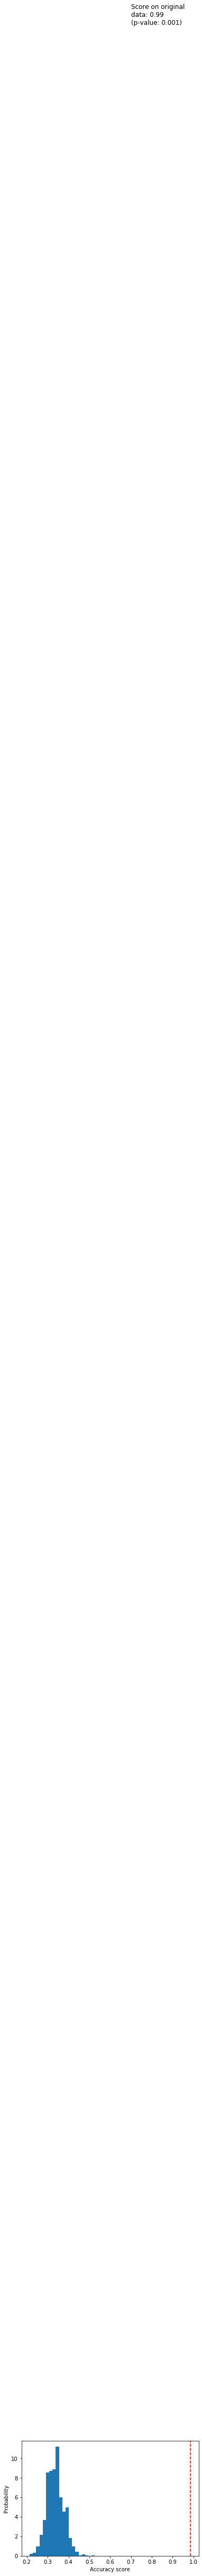

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(perm_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls='--', color='r')
score_label = (f"Score on original\ndata: {score_iris:.2f}\n"
               f"(p-value: {pvalue_iris:.3f})")
ax.text(0.7, 260, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

In [11]:
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(X)

In [73]:
scores = cross_val_score(clf_multi, X, y, cv=cv, n_jobs=1)
print(scores)

maxIter  30
ovr 1.0 1.0 30 0.0001 l2 True 0.0001 squared_hinge 100000
1 / 30
2 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



5 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



6 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



7 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



8 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



9 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



10 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



11 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



12 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



13 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



14 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



15 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



16 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



17 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



18 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



19 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



20 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



21 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



22 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



23 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



24 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



25 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



26 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



27 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



28 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



29 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



30 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



1 / 30
2 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



3 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



4 / 30
5 / 30
6 / 30
7 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



8 / 30
9 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



10 / 30
11 / 30
12 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



13 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



14 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



15 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



16 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



17 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



18 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



19 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



20 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



21 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



22 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



23 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



24 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



25 / 30


c:\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



26 / 30


KeyboardInterrupt: 

In [37]:
np.mean(scores), np.std(scores)

(0.5522727272727274, 0.07541209101380482)

In [33]:
for i,j in cv_split:
    print(len(i),len(j))

172 44
172 44
172 44
172 44
172 44
172 44
172 44
172 44
172 44
172 44


In [84]:
from spectrum import *
from scipy import fft
N=500
dt=2*10**-3
# Creating a signal with 2 sinus waves.
x = np.linspace(0.0, N*dt, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

# classical FFT
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)

# The multitapered method
NW=2.5
k=4
[tapers, eigen] = dpss(N, NW, k)
Sk_complex, weights, eigenvalues=pmtm(y, e=eigen, v=tapers, NFFT=N, show=False)

Sk = abs(Sk_complex)**2
Sk = np.mean(Sk * np.transpose(weights), axis=0) * dt

In [85]:
x.shape, Sk.shape

((500,), (500,))